# Comprehensive Validation Workflow: Putting It All Together

This notebook demonstrates a **comprehensive validation workflow** that combines all validation techniques to thoroughly test a model recommendation before deployment.

Understanding comprehensive validation is essential because:
- **No single technique catches everything** - you need multiple validation approaches
- **Validation prevents failures** - catching problems before deployment saves time and money
- **Systematic validation builds confidence** - you know the recommendation has been thoroughly tested
- **This is how professionals validate models** - comprehensive validation is standard practice


## Key Concepts

**Comprehensive Validation** combines multiple techniques:
- **Sensitivity Analysis**: Tests how recommendations change when inputs change
- **What-If Analysis**: Explores multiple complete scenarios
- **Extreme-Value Testing**: Tests model behavior at boundaries
- **Assumption Stress Testing**: Systematically breaks assumptions
- **Sanity Checks**: Applies business judgment to evaluate recommendations

**Why It Matters**:
- **Each technique catches different problems** - together they provide comprehensive coverage
- **Systematic validation prevents failures** - you catch problems before deployment
- **Validation builds confidence** - you know the recommendation has been thoroughly tested
- **It's a necessary step** - never deploy without validation

**Critical insight**: Comprehensive validation is like quality control - you check the recommendation thoroughly before using it, just like you check a product before selling it.


## Scenario: Production Planning Decision

You manage a factory and receive a model recommendation for next month's production plan. The model recommends:
- Produce 1,200 units of Product A
- Produce 800 units of Product B

**The Challenge**: Before implementing this recommendation, you need to validate it comprehensively using all validation techniques.

**The Question**: Does this recommendation pass comprehensive validation? Is it safe to deploy?

**Decision**: Whether to implement the production plan

**Validation techniques to apply**: All five techniques systematically


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value


## Step 3: Set Up the Model and Base Recommendation

First, let's set up the production planning model and get the base recommendation:


In [3]:
def solve_production_model(demand_A, demand_B, profit_A, profit_B, capacity, labor_hours, labor_per_A, labor_per_B):
    """Solve production planning model"""
    model = LpProblem("Production_Planning", LpMaximize)
    produce_A = LpVariable("produce_A", lowBound=0, cat='Integer')
    produce_B = LpVariable("produce_B", lowBound=0, cat='Integer')
    model += profit_A * produce_A + profit_B * produce_B, "Total_Profit"
    model += produce_A + produce_B <= capacity, "Capacity_Limit"
    model += labor_per_A * produce_A + labor_per_B * produce_B <= labor_hours, "Labor_Limit"
    model += produce_A <= demand_A, "Demand_A_Limit"
    model += produce_B <= demand_B, "Demand_B_Limit"
    model.solve()
    return (value(produce_A), value(produce_B), value(model.objective))

# Base inputs
base_demand_A = 1200
base_demand_B = 800
base_profit_A = 50
base_profit_B = 40
base_capacity = 2000
base_labor_hours = 1500
base_labor_per_A = 0.5
base_labor_per_B = 0.8

# Get base recommendation
base_A, base_B, base_profit = solve_production_model(
    base_demand_A, base_demand_B, base_profit_A, base_profit_B,
    base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
)

print("BASE MODEL RECOMMENDATION:")
print("=" * 80)
print(f"  Produce {base_A:.0f} units of Product A")
print(f"  Produce {base_B:.0f} units of Product B")
print(f"  Expected Profit: ${base_profit:,.0f}")
print(f"\nNow we'll validate this recommendation using all validation techniques...")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3e56d7ef24fb42beba5b677b1fb858b4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3e56d7ef24fb42beba5b677b1fb858b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 92000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -92000 to -1.79769e+308
Probing was tried 0 times and creat

## Step 4: Validation Technique 1 - Sensitivity Analysis

Test how sensitive the recommendation is to input changes:


In [4]:
# Sensitivity analysis: Test demand A
demand_A_values = np.arange(1100, 1301, 50)
sensitivity_results = []

for d_A in demand_A_values:
    prod_A, prod_B, profit = solve_production_model(
        d_A, base_demand_B, base_profit_A, base_profit_B,
        base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
    )
    sensitivity_results.append({
        'Demand_A': d_A,
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Change_A': prod_A - base_A
    })

sens_df = pd.DataFrame(sensitivity_results)
max_change_A = sens_df['Change_A'].abs().max()
sensitivity_ratio = abs(sens_df[sens_df['Demand_A'] == base_demand_A + 100]['Change_A'].values[0] / 100) if len(sens_df[sens_df['Demand_A'] == base_demand_A + 100]) > 0 else 0

print("VALIDATION 1: SENSITIVITY ANALYSIS")
print("=" * 80)
print(f"  Tested: Demand A from {demand_A_values.min()} to {demand_A_values.max()}")
print(f"  Maximum change in recommendation: {max_change_A:.0f} units")
print(f"  Sensitivity ratio: {sensitivity_ratio:.2f}")
if sensitivity_ratio > 0.5:
    print(f"  ⚠️  HIGHLY SENSITIVE - Recommendation changes significantly")
    sensitivity_status = "HIGH RISK"
elif sensitivity_ratio > 0.2:
    print(f"  ⚠️  MODERATELY SENSITIVE - Recommendation changes moderately")
    sensitivity_status = "MODERATE RISK"
else:
    print(f"  ✓  LOW SENSITIVITY - Recommendation is relatively stable")
    sensitivity_status = "LOW RISK"


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/87649f4e62ee4645acab89eb1cfd0376-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/87649f4e62ee4645acab89eb1cfd0376-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 87000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -87000 to -1.79769e+308
Probing was tried 0 times and creat

In [5]:
# What-if analysis: Test multiple scenarios
scenarios = {
    'Optimistic': {'demand_A': 1400, 'demand_B': 900},
    'Realistic': {'demand_A': 1200, 'demand_B': 800},
    'Pessimistic': {'demand_A': 1000, 'demand_B': 700}
}

whatif_results = {}
for scenario_name, scenario_data in scenarios.items():
    prod_A, prod_B, profit = solve_production_model(
        scenario_data['demand_A'], scenario_data['demand_B'],
        base_profit_A, base_profit_B, base_capacity, base_labor_hours,
        base_labor_per_A, base_labor_per_B
    )
    whatif_results[scenario_name] = {
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Profit': profit
    }

whatif_df = pd.DataFrame(whatif_results).T
profit_range = whatif_df['Profit'].max() - whatif_df['Profit'].min()

print("VALIDATION 2: WHAT-IF ANALYSIS")
print("=" * 80)
display(whatif_df.round(0))
print(f"\n  Profit range across scenarios: ${profit_range:,.0f}")
if profit_range > base_profit * 0.3:
    print(f"  ⚠️  HIGH VARIABILITY - Recommendation varies significantly across scenarios")
    whatif_status = "HIGH RISK"
else:
    print(f"  ✓  MODERATE VARIABILITY - Recommendation is relatively stable")
    whatif_status = "MODERATE RISK"


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/45ebe7f1b4ac4a43bbdb450bfef6003c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/45ebe7f1b4ac4a43bbdb450bfef6003c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 94000 - 0.00 seconds
Cgl0004I processed model has 1 rows, 2 columns (2 integer (0 of which binary)) and 2 elements
Cutoff increment increased from 1e-05 to 9.9999
Cbc0012I Integer solution of -94000 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0bada29a6e9b48b896b5c85dc4f9fc93-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/0bada29a6e9b48b896b5c85dc4f9fc93-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 78000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -78000 to -1.79769e+308
Probing was tried 0 times and creat

,Produce_A,Produce_B,Profit
Optimistic,1400.0,600.0,94000.0
Realistic,1200.0,800.0,92000.0
Pessimistic,1000.0,700.0,78000.0



  Profit range across scenarios: $16,000
  ✓  MODERATE VARIABILITY - Recommendation is relatively stable


## Step 6: Validation Technique 3 - Extreme-Value Testing

Test model behavior at boundaries:


In [6]:
# Extreme-value testing
extreme_tests = [
    {'name': 'Minimum Demand', 'demand_A': 500, 'demand_B': 400},
    {'name': 'Maximum Demand', 'demand_A': 1800, 'demand_B': 1200},
    {'name': 'Zero Demand A', 'demand_A': 0, 'demand_B': base_demand_B}
]

extreme_results = []
for test in extreme_tests:
    try:
        prod_A, prod_B, profit = solve_production_model(
            test['demand_A'], test['demand_B'],
            base_profit_A, base_profit_B, base_capacity, base_labor_hours,
            base_labor_per_A, base_labor_per_B
        )
        extreme_results.append({
            'Test': test['name'],
            'Produce_A': prod_A,
            'Produce_B': prod_B,
            'Valid': True
        })
    except:
        extreme_results.append({
            'Test': test['name'],
            'Produce_A': None,
            'Produce_B': None,
            'Valid': False
        })

extreme_df = pd.DataFrame(extreme_results)
all_valid = extreme_df['Valid'].all()

print("VALIDATION 3: EXTREME-VALUE TESTING")
print("=" * 80)
display(extreme_df)
if all_valid:
    print(f"  ✓  Model handles extremes - All tests passed")
    extreme_status = "PASS"
else:
    print(f"  ⚠️  Model breaks at extremes - Some tests failed")
    extreme_status = "FAIL"


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1af068140e364813b5d3d66cf4d60023-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1af068140e364813b5d3d66cf4d60023-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 41000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -41000 to -1.79769e+308
Probing was tried 0 times and creat

,Test,Produce_A,Produce_B,Valid
0,Minimum Demand,500.0,400.0,True
1,Maximum Demand,1800.0,200.0,True
2,Zero Demand A,0.0,800.0,True


  ✓  Model handles extremes - All tests passed


## Step 7: Validation Technique 4 - Assumption Stress Testing

Systematically break key assumptions:


In [7]:
# Assumption stress testing
stress_tests = [
    {'assumption': 'Demand A', 'base': base_demand_A, 'test': base_demand_A * 0.8},
    {'assumption': 'Demand B', 'base': base_demand_B, 'test': base_demand_B * 0.8},
    {'assumption': 'Capacity', 'base': base_capacity, 'test': base_capacity * 0.9}
]

stress_results = []
for test in stress_tests:
    if test['assumption'] == 'Demand A':
        prod_A, prod_B, profit = solve_production_model(
            test['test'], base_demand_B, base_profit_A, base_profit_B,
            base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    elif test['assumption'] == 'Demand B':
        prod_A, prod_B, profit = solve_production_model(
            base_demand_A, test['test'], base_profit_A, base_profit_B,
            base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    else:  # Capacity
        prod_A, prod_B, profit = solve_production_model(
            base_demand_A, base_demand_B, base_profit_A, base_profit_B,
            test['test'], base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    
    change_A = abs(prod_A - base_A)
    stress_results.append({
        'Assumption': test['assumption'],
        'Change %': ((test['test'] - test['base']) / test['base'] * 100),
        'Change in Recommendation': change_A,
        'Impact': 'High' if change_A > 100 else 'Moderate' if change_A > 50 else 'Low'
    })

stress_df = pd.DataFrame(stress_results)
max_impact = stress_df['Change in Recommendation'].max()

print("VALIDATION 4: ASSUMPTION STRESS TESTING")
print("=" * 80)
display(stress_df.round(0))
print(f"\n  Maximum impact: {max_impact:.0f} units change")
if max_impact > 100:
    print(f"  ⚠️  HIGH IMPACT - Critical assumptions identified")
    stress_status = "HIGH RISK"
else:
    print(f"  ✓  MODERATE IMPACT - Assumptions are manageable")
    stress_status = "MODERATE RISK"


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/d3fe694efd2743e297aaebcf28c81062-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/d3fe694efd2743e297aaebcf28c81062-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 22 RHS
At line 27 BOUNDS
At line 30 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 80000 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -80000 to -1.79769e+308
Probing was tried 0 times and creat

,Assumption,Change %,Change in Recommendation,Impact
0,Demand A,-20.0,240.0,High
1,Demand B,-20.0,0.0,Low
2,Capacity,-10.0,0.0,Low



  Maximum impact: 240 units change
  ⚠️  HIGH IMPACT - Critical assumptions identified


## Step 8: Validation Technique 5 - Sanity Checks

Apply business judgment to evaluate the recommendation:


In [8]:
# Sanity checks
sanity_checks = [
    {'Check': 'Is production possible?', 'Pass': base_A + base_B <= base_capacity, 'Issue': 'Exceeds capacity'},
    {'Check': 'Are quantities non-negative?', 'Pass': base_A >= 0 and base_B >= 0, 'Issue': 'Negative quantities'},
    {'Check': 'Does it meet minimum demand?', 'Pass': base_A <= base_demand_A * 1.2, 'Issue': 'Produces way more than demand'},
    {'Check': 'Is profit reasonable?', 'Pass': base_profit > 0, 'Issue': 'Negative profit'},
    {'Check': 'Is labor feasible?', 'Pass': base_labor_per_A * base_A + base_labor_per_B * base_B <= base_labor_hours, 'Issue': 'Exceeds labor hours'}
]

sanity_results = []
all_pass = True
for check in sanity_checks:
    sanity_results.append({
        'Check': check['Check'],
        'Passes': check['Pass'],
        'Status': '✓ PASS' if check['Pass'] else f'✗ FAIL: {check["Issue"]}'
    })
    if not check['Pass']:
        all_pass = False

sanity_df = pd.DataFrame(sanity_results)

print("VALIDATION 5: SANITY CHECKS")
print("=" * 80)
display(sanity_df)
if all_pass:
    print(f"  ✓  All sanity checks passed")
    sanity_status = "PASS"
else:
    print(f"  ⚠️  Some sanity checks failed - Recommendation has issues")
    sanity_status = "FAIL"


VALIDATION 5: SANITY CHECKS


,Check,Passes,Status
0,Is production possible?,True,✓ PASS
1,Are quantities non-negative?,True,✓ PASS
2,Does it meet minimum demand?,True,✓ PASS
3,Is profit reasonable?,True,✓ PASS
4,Is labor feasible?,True,✓ PASS


  ✓  All sanity checks passed


## Step 9: Validation Summary and Decision

Let's compile all validation results and make a decision:


In [9]:
# Compile validation summary
validation_summary = pd.DataFrame({
    'Validation Technique': [
        'Sensitivity Analysis',
        'What-If Analysis',
        'Extreme-Value Testing',
        'Assumption Stress Testing',
        'Sanity Checks'
    ],
    'Status': [
        sensitivity_status,
        whatif_status,
        extreme_status,
        stress_status,
        sanity_status
    ],
    'Key Finding': [
        f'Sensitivity ratio: {sensitivity_ratio:.2f}',
        f'Profit range: ${profit_range:,.0f}',
        f'Extreme tests: {"All passed" if all_valid else "Some failed"}',
        f'Max impact: {max_impact:.0f} units',
        f'Sanity checks: {"All passed" if all_pass else "Some failed"}'
    ]
})

print("COMPREHENSIVE VALIDATION SUMMARY:")
print("=" * 80)
display(validation_summary)

# Determine overall recommendation
risk_count = sum([1 for s in validation_summary['Status'] if 'RISK' in s or s == 'FAIL'])
if risk_count == 0:
    overall_status = "APPROVED - Safe to deploy"
    recommendation = "✓ IMPLEMENT - All validations passed"
elif risk_count <= 2:
    overall_status = "CONDITIONAL - Deploy with caution"
    recommendation = "⚠️  IMPLEMENT WITH MODIFICATIONS - Address identified risks"
else:
    overall_status = "REJECTED - Do not deploy"
    recommendation = "✗ DO NOT IMPLEMENT - Too many validation failures"

print(f"\nOVERALL VALIDATION RESULT:")
print("=" * 80)
print(f"  Status: {overall_status}")
print(f"  Risk Count: {risk_count} out of 5 validations")
print(f"  Recommendation: {recommendation}")

if risk_count > 0:
    print(f"\n  Issues to address:")
    for idx, row in validation_summary.iterrows():
        if 'RISK' in row['Status'] or row['Status'] == 'FAIL':
            print(f"    • {row['Validation Technique']}: {row['Key Finding']}")


COMPREHENSIVE VALIDATION SUMMARY:


,Validation Technique,Status,Key Finding
0,Sensitivity Analysis,HIGH RISK,Sensitivity ratio: 1.00
1,What-If Analysis,MODERATE RISK,"Profit range: $16,000"
2,Extreme-Value Testing,PASS,Extreme tests: All passed
3,Assumption Stress Testing,HIGH RISK,Max impact: 240 units
4,Sanity Checks,PASS,Sanity checks: All passed



OVERALL VALIDATION RESULT:
  Status: REJECTED - Do not deploy
  Risk Count: 3 out of 5 validations
  Recommendation: ✗ DO NOT IMPLEMENT - Too many validation failures

  Issues to address:
    • Sensitivity Analysis: Sensitivity ratio: 1.00
    • What-If Analysis: Profit range: $16,000
    • Assumption Stress Testing: Max impact: 240 units


## Step 10: Visualize Validation Results

Let's create a validation dashboard:


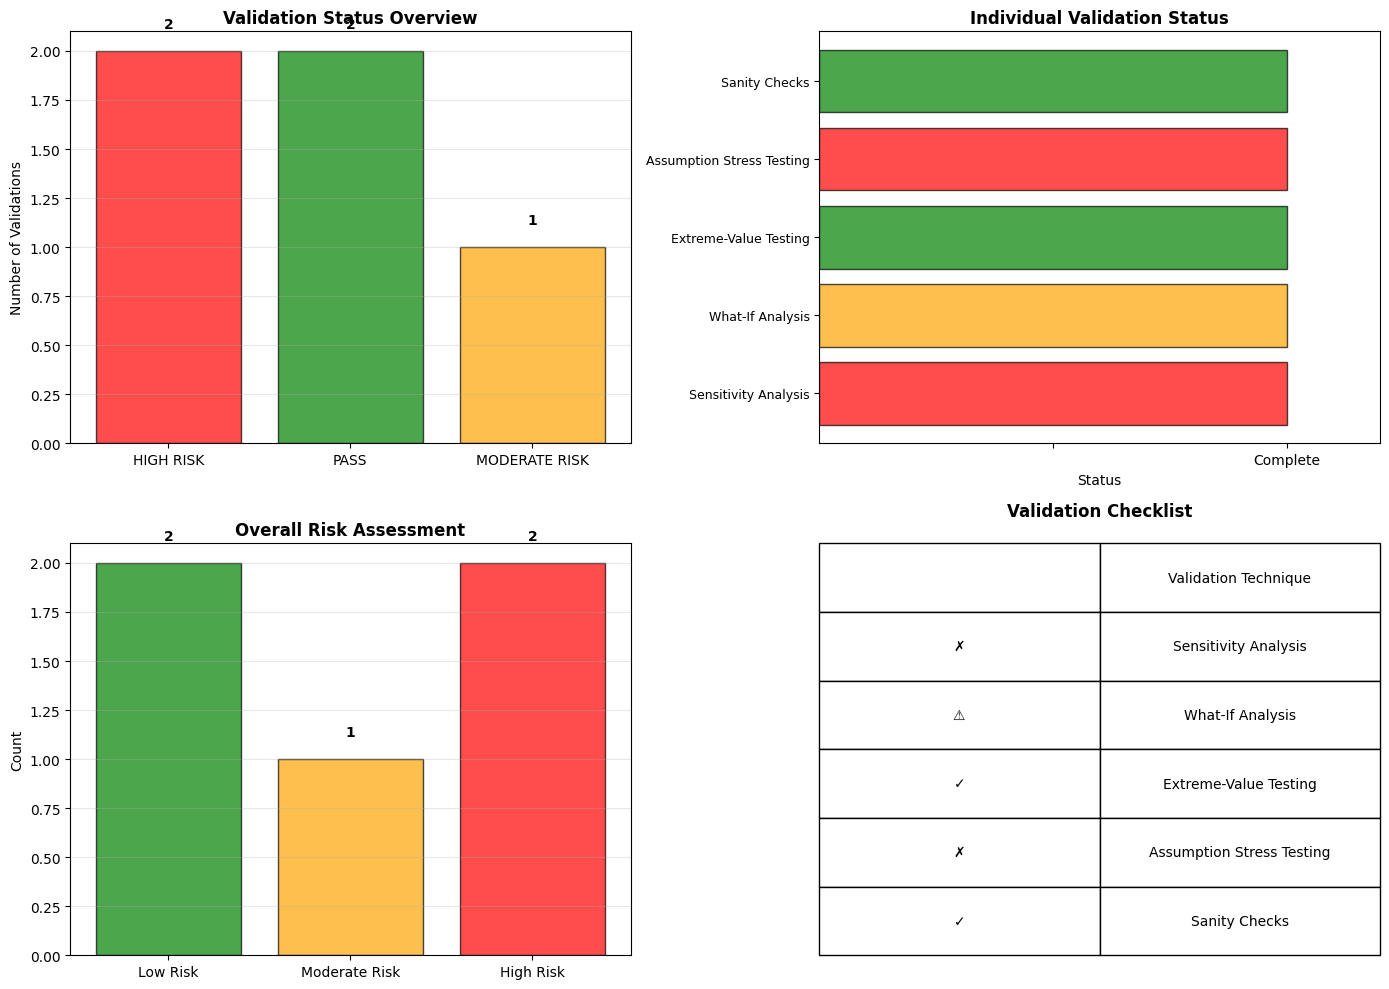

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Validation Status Overview
ax1 = axes[0, 0]
status_counts = validation_summary['Status'].value_counts()
colors_status = {'PASS': 'green', 'LOW RISK': 'lightgreen', 'MODERATE RISK': 'orange', 
                 'HIGH RISK': 'red', 'FAIL': 'darkred'}
status_colors = [colors_status.get(s, 'gray') for s in status_counts.index]
bars = ax1.bar(status_counts.index, status_counts.values, color=status_colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Validations')
ax1.set_title('Validation Status Overview', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, status_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Validation Techniques Status
ax2 = axes[0, 1]
y_pos = np.arange(len(validation_summary))
colors_bar = [colors_status.get(s, 'gray') for s in validation_summary['Status']]
bars = ax2.barh(y_pos, [1]*len(validation_summary), color=colors_bar, alpha=0.7, edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(validation_summary['Validation Technique'], fontsize=9)
ax2.set_xlabel('Status')
ax2.set_title('Individual Validation Status', fontweight='bold')
ax2.set_xlim(0, 1.2)
ax2.set_xticks([0.5, 1])
ax2.set_xticklabels(['', 'Complete'])

# Plot 3: Risk Assessment
ax3 = axes[1, 0]
risk_levels = ['Low Risk', 'Moderate Risk', 'High Risk']
risk_counts = [
    sum([1 for s in validation_summary['Status'] if s == 'LOW RISK' or s == 'PASS']),
    sum([1 for s in validation_summary['Status'] if s == 'MODERATE RISK']),
    sum([1 for s in validation_summary['Status'] if s == 'HIGH RISK' or s == 'FAIL'])
]
colors_risk = ['green', 'orange', 'red']
bars = ax3.bar(risk_levels, risk_counts, color=colors_risk, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Count')
ax3.set_title('Overall Risk Assessment', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, risk_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 4: Validation Checklist
ax4 = axes[1, 1]
ax4.axis('off')
checklist_data = validation_summary[['Validation Technique', 'Status']].copy()
checklist_data['Check'] = ['✓' if 'PASS' in s or s == 'LOW RISK' else '⚠️' if 'MODERATE' in s else '✗' for s in checklist_data['Status']]
table = ax4.table(cellText=checklist_data[['Check', 'Validation Technique']].values,
                 colLabels=['', 'Validation Technique'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax4.set_title('Validation Checklist', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()
